# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

In [1]:
import pandas as pd
import numpy as np
import random
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import bottleneck as bn
import math

### Exploratory Data Analysis

Our group would like to do some exploratory data analysis before diving into data cleaning.

In [2]:
# load the csv file into a pandas dataframe
df=pd.read_csv("https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv",encoding="utf-8")

In [3]:
# show the first five rows of the data
df.head()

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


In [4]:
# show summary statistics of each column
df.describe()

,part,company,country,city,price,date
count,20558,20568,18397,20535,20567,20568
unique,100,35,13,30,19214,20552
top,17156-617,Thoughtmix,Portugal,Amadora\t,-,10/04/2017
freq,300,2795,7383,2787,5,7


In [5]:
# check the column types
df.dtypes

part       object
company    object
country    object
city       object
price      object
date       object
dtype: object

In [6]:
# check the data type in each column
for column in df.columns:
    print("Data type in {} is {}.".format(column,type(df[column][0])))

Data type in part is <class 'str'>.
Data type in company is <class 'str'>.
Data type in country is <class 'str'>.
Data type in city is <class 'str'>.
Data type in price is <class 'str'>.
Data type in date is <class 'str'>.


In [7]:
# check for empty strings in each column
for column in df.columns:
    print("" in df[column])

False
False
False
False
False
False


In [8]:
# check for NaNs
for column in df.columns:
    print("column {} has {} null value".format(column, df[column].isnull().sum().sum()))

column part has 10 null value
column company has 0 null value
column country has 2171 null value
column city has 33 null value
column price has 1 null value
column date has 0 null value


From the result, it can be seen that except `company` and `date`, the rest columns have various number of missing values. In the next section, we will take a deeper look into each column and handle its missing values as well.

### Part Column

In [9]:
# count number of unique values in the part column
df.part.nunique()

100

In [10]:
# show the most frequent part names and their counts
df.part.value_counts(dropna = False).head()

17156-617     300
37205-992     295
52959-433     293
0268-6107     293
54868-0823    292
Name: part, dtype: int64

#### handle missing values in `part`

In [11]:
# locate rows whose part is missing
df[df.part.isnull()]

,part,company,country,city,price,date
14916,NaN,Yozio,Greece,Patras,518.38€,2018-02-17 21:43:43
14917,NaN,Brainsphere,Portugal,Braga,957.24€,2018-02-17 22:12:24
14918,NaN,Lajo,Greece,Thessaloniki,966.06€,2018-02-17 22:54:49
14919,NaN,Roodel,Portugal,Aranhas,873.65€,2018-02-17 23:36:52
17524,NaN,Yozio,Greece,Patras,627.32€,2018-07-12 03:28:46
17525,NaN,Thoughtmix,Portugal,Amadora\t,825.8€,2018-07-12 05:34:07
17526,NaN,Gabcube,Portugal,Almada,188.31€,2018-07-12 06:49:44
17527,NaN,Buzzbean,Germany,Düsseldorf,429.67€,2018-07-12 07:03:50
17528,NaN,Zoonder,United States,Boston,$521.72,2018-07-12 08:38:56
17529,NaN,Twitterbeat,France,Annecy,1031.46€,2018-07-12 09:48:17


In [12]:
# calculate proportion of missing values
prop_nan_part = len(df[df.part.isnull()])/len(df)
prop_nan_part

0.0004861921431349669

Since the proportion of missing values in the part column is only **0.049%** of the entire dataset, we can remove the rows with missing part entries.

In [13]:
# drop the missing values in part column 
df=df.dropna(subset=['part'])

In [14]:
# check if there is still any missing values in part column
df[df.part.isnull()]

,part,company,country,city,price,date


### Company Column

#### clean strings in `company`

In [15]:
# count number of unique values in the company column
df.company.unique()

array(['Chatterbridge', 'Lajo', 'Flipstorm', 'Twitterbeat', 'Voomm',
       'Buzzbean', 'Zooxo', 'Brainsphere', 'Thoughtmix', 'Wordify',
       'Teklist', 'Avaveo', 'Ntags', 'Innojam', 'Shufflebeat', 'Zoonder',
       'Kanoodle', 'Gabcube', 'Roodel', 'Riffpath', 'Eimbee', 'Yozio',
       'Rhycero', 'Realpoint', 'Gabtune', 'Bubblemix', 'Gevee', 'Tagtune',
       'Zooxo.', 'Laj0', 'Ntagz', ' -', ' a', 'aa', 'Thoughtmixz'],
      dtype=object)

In [16]:
# show the number of occurrences of each company
df.company.value_counts(dropna=False)

Thoughtmix       2794
Twitterbeat      2267
Zooxo            1670
Chatterbridge    1589
Shufflebeat      1553
Ntags            1514
Buzzbean         1253
Brainsphere      1241
Flipstorm        1193
Wordify           968
Yozio             653
Roodel            626
Eimbee            498
Zoonder           453
Teklist           428
Gabcube           356
Voomm             250
Lajo              219
Avaveo            212
Rhycero           204
Realpoint         158
Riffpath          151
Kanoodle          127
Bubblemix          54
Innojam            44
Gevee              36
Gabtune            27
Tagtune            12
Zooxo.              2
aa                  1
 a                  1
Laj0                1
 -                  1
Thoughtmixz         1
Ntagz               1
Name: company, dtype: int64

From the above result, it can be seen that some erroneous company names/poorly formatted company names. These include:
* ` a`,`aa`,` -` each has occurred once in the dataset. They are likely to be the erroneous entries. Simply remove them.
* `Laj0` should be standardized to `Lajo`. Likewise, `Zooxo.` should be standardized to `Zooxo`; `Thoughtmixz` should be standardized to `Thoughtmix`; `Ntagz` should be standardized to `Ntags`

In [17]:
# remove erroneous company names
df.company = df.company.replace([' a','aa',' -'], '')
df=df[df.company != '']

In [18]:
# standardize the poorly formatted company names
df.company = df.company.replace('Zooxo.','Zooxo')
df.company = df.company.replace('Laj0','Lajo')
df.company = df.company.replace('Thoughtmixz','Thoughtmix')
df.company = df.company.replace('Ntagz','Ntags')

In [19]:
# check the number of occurrences of each company again
df.company.value_counts(dropna=False)

Thoughtmix       2795
Twitterbeat      2267
Zooxo            1672
Chatterbridge    1589
Shufflebeat      1553
Ntags            1515
Buzzbean         1253
Brainsphere      1241
Flipstorm        1193
Wordify           968
Yozio             653
Roodel            626
Eimbee            498
Zoonder           453
Teklist           428
Gabcube           356
Voomm             250
Lajo              220
Avaveo            212
Rhycero           204
Realpoint         158
Riffpath          151
Kanoodle          127
Bubblemix          54
Innojam            44
Gevee              36
Gabtune            27
Tagtune            12
Name: company, dtype: int64

In [20]:
# check if there is any missing values in company column
df[df['company'].isnull()]

,part,company,country,city,price,date


### Country Column

#### clean strings in `country`

In [21]:
# count number of unique values in the country column
df.country.unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland',
       nan, 'US', 'Tyskland', 'Portuga'], dtype=object)

From the `unique()` result, we can see that `United States` and `US` are the same and thus should be standardized. 
<br>
Similarly, `Portugal` and `Portuga` should be standardized. 
<br>
Additionally, `Tyskland` means `Germany` in Swedish. Thus they need to be standardized too.

In [22]:
# standaerdize the poorly formatted country names 
df.country = df.country.replace('US', 'United States')
df.country = df.country.replace('Portuga', 'Portugal')
df.country = df.country.replace('Tyskland', 'Germany')

In [23]:
# check the unique values again to make sure that all errorneous entries have been removed
df.country.unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland',
       nan], dtype=object)

#### handle missing values in  `country` 

In [24]:
# locate the first five rows with missing value in the country column 
df[df.country.isnull()].head()

,part,company,country,city,price,date
2528,52380-1102,Teklist,NaN,Arnhem,357.78,2016-04-21 04:07:31
2947,52125-136,Brainsphere,NaN,Braga,493.94€,2016-05-10 11:13:43
2956,16714-295,Teklist,NaN,Arnhem,624.4€,2016-05-10 21:57:15
2994,76335-006,Buzzbean,NaN,Düsseldorf,355.24€,2016-05-12 15:17:37
3948,54473-578,Brainsphere,NaN,Braga,123.32€,2016-07-01 01:09:40


In [25]:
# count number of missing values in the country column 
len(df[df.country.isnull()])

2171

In [26]:
# count the proportion of missing values in the country column 
prop_nan_country = len(df[df.country.isnull()])/len(df)
prop_nan_country

0.1056190707856969

Since the fraction of missing values in the country column is **10.43%** of the entire dataset which is considerably large, we cannot simply remove the rows with missing countries entries as doing so will result in much information being lost.
<br>
<br>
Instead, we can **deduce some of the country names from their corresponding cities**.

In [27]:
# group by city and count number of occurrences of each city
df.groupby(['city'])['country'].value_counts(dropna = False).head()

city       country 
Almada     Portugal     323
           NaN           33
Amadora\t  Portugal    2511
           NaN          275
Amiens     France       452
Name: country, dtype: int64

In [28]:
# map city to its country
city_country_mapping = df.groupby(['city'])['country'].apply(lambda grp: list(grp.value_counts().index)[0]).to_dict()
city_country_mapping

{'Almada': 'Portugal',
 'Amadora\t': 'Portugal',
 'Amiens': 'France',
 'Amsterdam': 'Netherlands',
 'Annecy': 'France',
 'Aranhas': 'Portugal',
 'Arcueil': 'France',
 'Arnhem': 'Netherlands',
 'Asaka': 'Japan',
 'Athens': 'Greece',
 'Barcelona': 'Spain',
 'Boston': 'United States',
 'Braga': 'Portugal',
 'Champagnole': 'France',
 'Düsseldorf': 'Germany',
 'Heraklion': 'Greece',
 'Lisbon': 'Portugal',
 'London': 'United Kingdom',
 'Lyon': 'France',
 'Monção': 'Portugal',
 'Nanterre': 'France',
 'New York': 'United States',
 'Nice': 'France',
 'Niihama': 'Japan',
 'Paris': 'France',
 'Patras': 'Greece',
 'Porto': 'Portugal',
 'Thessaloniki': 'Greece',
 'Vila Fria': 'Portugal',
 'Zürich': 'Switzerland'}

In [29]:
# check the index of missing value in the contry column 
df[df.country.isnull()].index

Int64Index([ 2528,  2947,  2956,  2994,  3948,  3949,  3950,  3951,  3952,
             3953,
            ...
            12843, 12978, 13721, 14438, 16146, 16147, 16148, 16149, 16150,
            16151],
           dtype='int64', length=2171)

In [30]:
# function to deduce the country for a given city
def impute_countries(row):
    try:
        res=city_country_mapping[row.city]
    except KeyError:
        res=float('NaN')
    return res

In [31]:
# deduce the country for every row in the data
df.country = df.apply(impute_countries, axis = 1)

In [32]:
# check the number of missing values after imputation
len(df[df.country.isna()])

33

In [33]:
df[df.country.isna()]

,part,company,country,city,price,date
3136,68462-565,Brainsphere,NaN,NaN,1057.85€,2016-05-20 08:59:53
3137,54092-515,Shufflebeat,NaN,NaN,772.92€,2016-05-20 09:55:24
3138,0185-0373,Brainsphere,NaN,NaN,1012.8€,2016-05-20 10:42:10
12820,50563-113,Ntags,NaN,NaN,507.49€,2017-10-20 04:03:11
12821,55154-5057,Brainsphere,NaN,NaN,421.64€,2017-10-20 13:23:34
12822,36987-1697,Ntags,NaN,NaN,937.08€,2017-10-20 18:25:00
12823,68462-565,Thoughtmix,NaN,NaN,777.58€,2017-10-20 21:21:18
12824,0603-6134,Yozio,NaN,NaN,775.05€,2017-10-20 23:17:59
12825,58118-5060,Yozio,NaN,NaN,157.53€,2017-10-20 23:49:53
12826,51060-032,Thoughtmix,NaN,NaN,176.36€,2017-10-21 00:11:55


**The number of missing values in the country column reduces from 2171 to 33 after imputing country names***. For the remaining 33 rows of missing values, both their `country` and `city` are missing making it impossible to deduce the country. We can then drop these rows which is done in the next section, `city column`.

### City Column

#### clean strings in `city`

In [34]:
# count number of unique values in the city column
df.city.unique()

array(['Barcelona', 'Thessaloniki', 'Athens', 'Annecy', 'Paris',
       'Düsseldorf', 'London', 'Braga', 'Nanterre', 'Amadora\t',
       'New York', 'Arnhem', 'Nice', 'Lisbon', 'Amsterdam', 'Porto',
       'Boston', 'Niihama', 'Almada', 'Aranhas', 'Heraklion', 'Amiens',
       'Patras', 'Arcueil', 'Lyon', 'Asaka', 'Champagnole', 'Zürich', nan,
       'Monção', 'Vila Fria'], dtype=object)

Result from `unique()` shows that there is an additional `\t` in the city `Amadora`. Remove the`\t`s:

In [35]:
# remove '\t'
df.city = df.city.str.replace("\t","")

In [36]:
# check the unique values again to make sure that all errorneous entries have been removed
df.city.unique()

array(['Barcelona', 'Thessaloniki', 'Athens', 'Annecy', 'Paris',
       'Düsseldorf', 'London', 'Braga', 'Nanterre', 'Amadora', 'New York',
       'Arnhem', 'Nice', 'Lisbon', 'Amsterdam', 'Porto', 'Boston',
       'Niihama', 'Almada', 'Aranhas', 'Heraklion', 'Amiens', 'Patras',
       'Arcueil', 'Lyon', 'Asaka', 'Champagnole', 'Zürich', nan, 'Monção',
       'Vila Fria'], dtype=object)

#### handle missing values in `city`

In [37]:
# locate rows with missing values in the city column
df[df.city.isnull()]

,part,company,country,city,price,date
3136,68462-565,Brainsphere,NaN,NaN,1057.85€,2016-05-20 08:59:53
3137,54092-515,Shufflebeat,NaN,NaN,772.92€,2016-05-20 09:55:24
3138,0185-0373,Brainsphere,NaN,NaN,1012.8€,2016-05-20 10:42:10
12820,50563-113,Ntags,NaN,NaN,507.49€,2017-10-20 04:03:11
12821,55154-5057,Brainsphere,NaN,NaN,421.64€,2017-10-20 13:23:34
12822,36987-1697,Ntags,NaN,NaN,937.08€,2017-10-20 18:25:00
12823,68462-565,Thoughtmix,NaN,NaN,777.58€,2017-10-20 21:21:18
12824,0603-6134,Yozio,NaN,NaN,775.05€,2017-10-20 23:17:59
12825,58118-5060,Yozio,NaN,NaN,157.53€,2017-10-20 23:49:53
12826,51060-032,Thoughtmix,NaN,NaN,176.36€,2017-10-21 00:11:55


In [38]:
# count the number of missing values in the city column
len(df[df.city.isnull()])

33

In [39]:
# group by 'company' then 'country' then 'city'
df.groupby(["company","country",'city']).count()

part  price  date
company       country        city                           
Avaveo        France         Nice           212    212   212
Brainsphere   Portugal       Braga         1236   1236  1236
                             Monção           1      1     1
Bubblemix     Japan          Asaka           54     54    54
Buzzbean      Germany        Düsseldorf    1253   1253  1253
Chatterbridge Spain          Barcelona     1589   1589  1589
Eimbee        France         Amiens         498    498   498
Flipstorm     France         Nanterre       381    381   381
              Greece         Athens         812    812   812
Gabcube       Portugal       Almada         356    356   356
Gabtune       France         Lyon            27     27    27
Gevee         France         Champagnole     36     36    36
Innojam       Netherlands    Amsterdam       44     44    44
Kanoodle      Japan          Niihama        126    126   126
Lajo          Greece         Thessaloniki   220    220   220
Ntags         Portugal       Lisbon        1509   1509  1509
Realpoint     Portugal       Lisbon         158    158   158
Rhycero       France         Arcueil        204    204   204
Riffpath      Greece         Heraklion      151    151   151
Roodel        Portugal       Aranhas        626    625   626
Shufflebeat   Portugal       Porto         1550   1550  1550
Tagtune       Switzerland    Zürich          12     12    12
Teklist       Netherlands    Arnhem         426    426   426
Thoughtmix    Portugal       Amadora       2786   2786  2786
                             Vila Fria        1      1     1
Twitterbeat   France         Annecy        2266   2266  2266
Voomm         France         Paris          250    250   250
Wordify       United States  New York       966    966   966
Yozio         Greece         Patras         651    651   651
Zoonder       United States  Boston         452    452   452
Zooxo         United Kingdom London        1669   1669  1669

From the `groupby` result, it can be seen that a company can correspond to multiple countries and cities, as they are likely to have branches in different places.

In [40]:
#calculate the proportion of NaN in city column
prop_nan_city = len(df[df.city.isnull()])/len(df)
prop_nan_city

0.001605448795913403

Since the proportion of missing values in the city column is only **0.16%** of the entire dataset, we can remove the rows with missing city entries.

In [41]:
# drop the missing values in city column. This will drop NAs in the country column as well
df=df.dropna(subset=['city'])

In [42]:
# check if there is still any missing value
df[df.city.isnull()]

,part,company,country,city,price,date


### Date Column

In [43]:
# convert the strings in the date column to datetime objects, and store them in a new column called parsed_date
df['parsed_date'] = pd.to_datetime(df['date'],errors='coerce', infer_datetime_format=True)

In [44]:
# check for rows with non-datetime objects in the parsed_date
df[df.parsed_date.isnull()]

,part,company,country,city,price,date,parsed_date
3539,17156-617,Thoughtmix,Portugal,Amadora,791.86€,2016-06-32 07:22:28,NaT
3540,54868-5165,Shufflebeat,Portugal,Porto,525.24€,2016-06-32 08:08:48,NaT


From the result above, it can be seen that the NaTs are due to the original date being 32nd of June, which is non-existent. Therefore, we remove these two rows.

In [45]:
# drop NaTs in the parsed_date column
df = df.dropna()

In [46]:
# check if there is still any missing value
df[df.parsed_date.isnull()]

,part,company,country,city,price,date,parsed_date


### Price Column

In [47]:
# original intention was to find all currency symbols present
# but it turned out that there are other poorly formatted cells other than currency signs
res=[]
for p in df.price:
    for c in p:
        if c.isdigit() == False:
            res.append(c)
x=np.array(res)
np.unique(x)

array(['$', '-', '.', 'a', 'd', 'i', 'n', 'o', 'v', '£', '¥', '€'],
      dtype='<U1')

In [48]:
# find what are those cells
res=[]
for p in df.price:
    for c in p:
        if c in ['a', 'd', 'i', 'n', 'o', 'v']:
            print(p)
            break

void
void
na
na
na


Our group will remove rows with entries such as "void" and "na"

In [49]:
# remove rows with "void" and "na"
print(len(df)) # number of rows before removal
df=df[df.price != 'void']
df=df[df.price != 'na']
print(len(df)) # number of rows after removal

20519
20514


The function below will parse the amount of price out as floating type.

In [50]:
def parse_price(string):
    amount=re.match(r'([^-\d\.]?)(-?\d*\.?\d*)([\D]?)', str(string))
    lst=[i for i in amount.groups() if i != '']
    try:
        res=float(lst[0])
    except ValueError:
        res=float(lst[1])
    return res

The function below will parse the currency symbol of price out as string type.

In [51]:
def parse_symbol(string):
    amount=re.match(r'([^-\d\.]?)(-?\d*\.?\d*)([\D]?)', str(string))
    lst=[i for i in amount.groups() if i != '']
#     if len(lst) != 2:
#         return float('NaN')
    try:
        number=float(lst[0])
        sign=lst[1]
    except ValueError:
        sign=lst[0]
    return sign

The function below will correspond each currency to its universal short forms.

In [52]:
def find_currency(string):
    currency=re.findall("[€$¥£]",string)
    if currency:
        symbol=currency[0]
        if symbol == "€":
            return "EUR"
        elif symbol == "$":
            return "USD"
        elif symbol == "¥":
            return "CNY"
        elif symbol == "£":
            return "GBP"
    else:
        print("error: can't find currenct symbol in {}".format(string))

There are a few rows with missing or invalid currency symbols entries. We will remove these rows.

In [53]:
df["currency"]=df.price.apply(find_currency)

error: can't find currenct symbol in 465.6
error: can't find currenct symbol in 1266.68
error: can't find currenct symbol in 829.3
error: can't find currenct symbol in 357.78
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -


In [54]:
# remove rows with missing/invalid currency symbols
df=df[df['price'] != "465.6"]
df=df[df['price'] != "1266.68"]
df=df[df['price'] != "829.3"]
df=df[df['price'] != "357.78"]
df=df[df['price'] != "-"]

In [55]:
# create a column price_amount to store the numeric portion of the price
df['price_amount']=df.price.apply(parse_price)

In [56]:
# create a column price_amount to store the price symbols
df['price_symbol']=df.price.apply(parse_symbol)

In [57]:
df.tail()

,part,company,country,city,price,date,parsed_date,currency,price_amount,price_symbol
20563,21695-267,Roodel,Portugal,Aranhas,606.37€,2018-12-31 20:48:14,2018-12-31 20:48:14,EUR,606.37,€
20564,49999-737,Thoughtmix,Portugal,Amadora,828.37€,2018-12-31 21:24:17,2018-12-31 21:24:17,EUR,828.37,€
20565,52343-025,Brainsphere,Portugal,Braga,686.1€,2018-12-31 21:38:02,2018-12-31 21:38:02,EUR,686.10,€
20566,49288-0285,Flipstorm,Greece,Athens,1051.08€,2019-02-21 20:05:00,2019-02-21 20:05:00,EUR,1051.08,€
20567,43419-018,Flipstorm,Greece,Athens,139.56€,2019-05-14 22:48:39,2019-05-14 22:48:39,EUR,139.56,€


In [58]:
# check for missing values
df.isnull().sum().sum()

0

### Final Cleaning

In [59]:
# drop the original date column
df=df.drop(columns='date')

# rename columns
df.rename(columns={"parsed_date" : "date", 
                   "currency": "currency_name",
                   "price_symbol":"currency_symbol"}, inplace=True)

In [60]:
df.head()

,part,company,country,city,price,date,currency_name,price_amount,currency_symbol
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€


---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

In [61]:
import datetime
from forex_python.converter import CurrencyRates

#### External Data 1 --> Exchange Rate
In the dataset, transactions are recorded in different currencies. Our group intends to standardize them into USD.

Additionally, since the exchnage rate is changing every day. Our group will extract the exchange rate on the day and time that a trasaction are performed. We will then standardize the original price into USD.

In [62]:
c = CurrencyRates()

In [63]:
# function to perform currency conversions
def ToUSD(currency,date):
    return c.convert(currency, 'USD', 1 , date)

In [64]:
# function to standardize every profit to USD according to its currency and time of transaction
USD=[] # stores the exchange rates to USD for each row
dic={}

for i in range(len(df)):
    if i == 2000:
        print("I'm 10% done!")
    if i == 5000:
        print("Hang on, Ms.Pretty/Mr.Handsome. I'm doing my best!")
    if i == 10000:
        print("Yeah, I'm 50% done!")
    if i == 15000:
        print("Waiting is boring, why not sing a song? La la la ~")
    if i == 20000:
        print("Almost there, give me 10s!")
    
    date=df.iloc[i,5].date()
    currency=df.iloc[i,6]
    key=(currency,date)
    
    if key in dic:
        USD.append(dic[key])
    else:
        dic[key] = ToUSD(currency,date)
        USD.append(dic[key])

print("YAS! I'm done!")

I'm 10% done!
Hang on, Ms.Pretty/Mr.Handsome. I'm doing my best!
Yeah, I'm 50% done!
Waiting is boring, why not sing a song? La la la ~
Almost there, give me 10s!
YAS! I'm done!


In [65]:
# append exchange rates to the dataframe
df['exchange_rate_to_USD'] = USD

In [66]:
# calculate the standardized amount in USD
df['standardized_USD'] = df.price_amount * df.exchange_rate_to_USD

In [67]:
df=df.reset_index(drop=True)

In [68]:
df.tail()

,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD
20500,21695-267,Roodel,Portugal,Aranhas,606.37€,2018-12-31 20:48:14,EUR,606.37,€,1.1450,694.293650
20501,49999-737,Thoughtmix,Portugal,Amadora,828.37€,2018-12-31 21:24:17,EUR,828.37,€,1.1450,948.483650
20502,52343-025,Brainsphere,Portugal,Braga,686.1€,2018-12-31 21:38:02,EUR,686.10,€,1.1450,785.584500
20503,49288-0285,Flipstorm,Greece,Athens,1051.08€,2019-02-21 20:05:00,EUR,1051.08,€,1.1354,1193.396232
20504,43419-018,Flipstorm,Greece,Athens,139.56€,2019-05-14 22:48:39,EUR,139.56,€,1.1226,156.670056


save the above dataframe for easy access:

#### External Data 2 --> GDP
Since we are going to find out which clients becomes less profitable and the reasons behind it, our group feels GDP of that country may be useful.

Source of data : https://data.worldbank.org/indicator/ny.gdp.mktp.cd

In [69]:
# load data into pandas dataframe
GDP=pd.read_csv("https://raw.githubusercontent.com/YangYuesong0323/Computational_Tools/master/GDP.csv")

In [70]:
# prepare and organize the original data
GDP=GDP.drop(columns=['Country Code','Indicator Name','Indicator Code'])
GDP=GDP.rename(columns={'Country Name':'country'})
GDP_long=pd.melt(GDP,id_vars=['country'], var_name='year', value_name='value')

In [71]:
# show the first five rows of the GDP data
GDP_long.head()

,country,year,value
0,Aruba,1960,NaN
1,Afghanistan,1960,537777811.1
2,Angola,1960,NaN
3,Albania,1960,NaN
4,Andorra,1960,NaN


#### External Data 3 --> Population
Same reasons as GDP, our group feels the total population may also play a part in the declining profits. Population value is in unit of thousands.

Source of data : https://data.worldbank.org/indicator/SP.POP.TOTL

In [72]:
# load data into pandas dataframe
Population=pd.read_csv("https://raw.githubusercontent.com/YangYuesong0323/Computational_Tools/master/population.csv")

In [73]:
# prepare and organize the original data
Population=Population.drop(columns=['Country Code','Indicator Name','Indicator Code'])
Population=Population.rename(columns={'Country Name':'country'})
Population_long=pd.melt(Population,id_vars=['country'], var_name='year', value_name='value')

In [74]:
# show the first five rows of the GDP data
Population_long.head()

,country,year,value
0,Aruba,1960,54211.0
1,Afghanistan,1960,8996973.0
2,Angola,1960,5454933.0
3,Albania,1960,1608800.0
4,Andorra,1960,13411.0


---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

#### create a database named `project1`

In [75]:
import sqlite3

In [76]:
conn = sqlite3.connect('project1.sqlite')
c = conn.cursor()

#### create a table named `customer` from the pandas dataframe `df`

Since the current dataframe `df` does not have a primary key, we create another column called `key` and fill this column with the index of each row, i.e. use the row index as the primary key 

In [77]:
# insert a column that records down the row index at position 0 (first column) 
df.insert(0, 'key', range(len(df)))

In [78]:
df.head()

,key,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD
0,0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€,1.0887,854.400873
1,1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€,1.0887,204.664713
2,2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€,1.0887,241.397451
3,3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€,1.0887,1171.245234
4,4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€,1.0887,449.143185


add two additional columns, year and months, to the dataframe `df` 

In [79]:
# create two new columns, each recording the year and month portion of the data
df['year'] = df.date.apply(lambda x : x.year)
df['month'] = df.date.apply(lambda x : x.month)

In [80]:
df.head()

,key,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD,year,month
0,0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€,1.0887,854.400873,2016,1
1,1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€,1.0887,204.664713,2016,1
2,2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€,1.0887,241.397451,2016,1
3,3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€,1.0887,1171.245234,2016,1
4,4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€,1.0887,449.143185,2016,1


In [81]:
df.columns

Index(['key', 'part', 'company', 'country', 'city', 'price', 'date',
       'currency_name', 'price_amount', 'currency_symbol',
       'exchange_rate_to_USD', 'standardized_USD', 'year', 'month'],
      dtype='object')

create the `customer` table with sqlite3

In [82]:
# drop any existing customer table
c.execute('''DROP TABLE IF EXISTS customer;''')
conn.commit()

In [83]:
# create a customer table with the correpsonding columns and column types
c.execute('''CREATE TABLE IF NOT EXISTS customer(
key INTEGER PRIMARY KEY, 
part varchar(20), 
company varchar(20), 
country varchar(30), 
city varchar(20), 
price varchar(10), 
date DATETIME, 
currency_name varchar(3), 
price_amount float(10), 
currency_symbol varchar(1), 
exchange_rate_to_USD float(10), 
standardized_USD float(10),
year DATETIME,
month DATETIME,
FOREIGN KEY (company, year) REFERENCES gdp(company, year))''')
conn.commit()

In [84]:
df.to_sql('customer', conn, if_exists='replace', index=False)
conn.commit()

In [85]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT Count(*) FROM customer')
print('number of rows in the sqlite customer table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas df dataframe is {}'.format(len(df)))

number of rows in the sqlite customer table is 20505
number of rows in the pandas df dataframe is 20505


In [86]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT * FROM customer')
print('first row in the sqlite customer table is {}'.format(c.fetchone()))
print()
print('first row in the pandas df dataframe is {}'.format(tuple(df.iloc[0])))

first row in the sqlite customer table is (0, '54868-5165', 'Chatterbridge', 'Spain', 'Barcelona', '784.79€', '2016-01-02 00:01:05', 'EUR', 784.79, '€', 1.0887, 854.4008729999999, 2016, 1)

first row in the pandas df dataframe is (0, '54868-5165', 'Chatterbridge', 'Spain', 'Barcelona', '784.79€', Timestamp('2016-01-02 00:01:05'), 'EUR', 784.79, '€', 1.0887, 854.4008729999999, 2016, 1)


#### create a table named `gdp` from the pandas dataframe `GDP_long`

In [87]:
GDP_long.columns

Index(['country', 'year', 'value'], dtype='object')

In [88]:
# drop any existing gdp table
c.execute('''DROP TABLE IF EXISTS gdp;''')
conn.commit()

None of the attributes can uniquely identify the row entries. However, we can uniquely identify a row by using `country` and `year` combined. Therefore, we set `country` and `year` as the composite key to the table. 

In [89]:
# create a gdp table with the correpsonding columns and column types
c.execute('''CREATE TABLE IF NOT EXISTS gdp( 
country varchar(64), 
year varchar(10), 
value float(10),
PRIMARY KEY (country, year))''')
conn.commit()

In [90]:
GDP_long.to_sql('gdp', conn, if_exists='replace', index=False)
conn.commit()

In [91]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT Count(*) FROM gdp')
print('number of rows in the sqlite gdp table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas GDP_long dataframe is {}'.format(len(GDP_long)))

number of rows in the sqlite gdp table is 15576
number of rows in the pandas GDP_long dataframe is 15576


In [92]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT * FROM gdp')
print('first row in the sqlite gdp table is {}'.format(c.fetchone()))
print()
print('first row in the pandas GDP_long dataframe is {}'.format(tuple(GDP_long.iloc[0])))

first row in the sqlite gdp table is ('Aruba', '1960', None)

first row in the pandas GDP_long dataframe is ('Aruba', '1960', nan)


#### create a table named `population` from the pandas dataframe `Population_long`

In [93]:
Population_long.columns

Index(['country', 'year', 'value'], dtype='object')

In [94]:
# drop any existing population table
c.execute('''DROP TABLE IF EXISTS population;''')
conn.commit()

None of the attributes can uniquely identify the row entries. However, we can uniquely identify a row by using `country` and `year` combined. Therefore, we set `country` and `year` as the composite key to the table. 

In [95]:
# create a population table with the correpsonding columns and column types
c.execute('''CREATE TABLE IF NOT EXISTS population(
country varchar(64), 
year varchar(10), 
value float(10),
PRIMARY KEY (country, year))''')
conn.commit()

In [96]:
Population_long.to_sql('population', conn, if_exists='replace', index=False)
conn.commit()

In [97]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT Count(*) FROM population')
print('number of rows in the sqlite population table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas Population_long dataframe is {}'.format(len(Population_long)))

number of rows in the sqlite population table is 15576
number of rows in the pandas Population_long dataframe is 15576


In [98]:
# code to test whether the sqlite table created is the same as the original pandas dataframe
c.execute('SELECT * FROM population')
print('first row in the sqlite population table is {}'.format(c.fetchone()))
print()
print('first row in the pandas Population_long dataframe is {}'.format(tuple(Population_long.iloc[0])))

first row in the sqlite population table is ('Aruba', '1960', 54211.0)

first row in the pandas Population_long dataframe is ('Aruba', '1960', 54211.0)


---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

#### <font color = "purple"> Q1: Who are the most profitable clients?<font>
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

**To answer this question, we have defined a function `topN` to display the top N companies with the highest total profits, both in tabular and in graphical forms.**

In [99]:
# helper function to decompose the topN_list obtained from the sql query
def decomposeList(index, lst):
    return [x[index] for x in lst]

In [100]:
# This function takes in an integer and return a table and a graph
def TopN(num):
        
    # SQL query to select the top N most profitable companies
    c.execute('''
    SELECT company, sum(standardized_USD) as ProfitSum
    FROM customer
    Group By company
    Order By ProfitSum DESC
    Limit ?
    ''', (num,))
    
    topN_list=c.fetchall()
    
    # consolidate the result into a pandas dataframe
    topN_df = pd.DataFrame(topN_list, columns=['company', 'total profits'])
    print("The top {} most profitable clients are:".format(num))
    print()
    
    # print the table
    print(topN_df)
    
    # a bar plot to visualize the total profits of the top N clients in descending order
    plt.figure(figsize=(12,5))
    plt.bar(x=decomposeList(0,topN_list), height=decomposeList(1,topN_list))
    plt.title("Top {} Clients With The Largest Total Profits".format(num))
    plt.xlabel("Client Name")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total Profit")  
    plt.show()
    return None

The top 5 most profitable clients are:

       company  total profits
0   Thoughtmix   1.845760e+06
1  Twitterbeat   1.508610e+06
2     Kanoodle   1.347284e+06
3        Zooxo   1.132010e+06
4  Shufflebeat   1.047283e+06


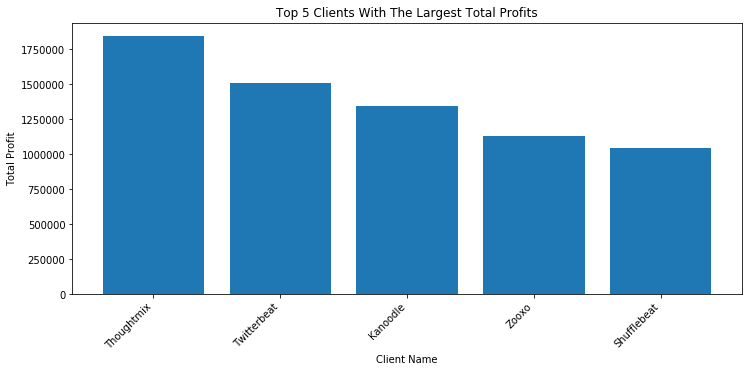

In [101]:
# for example, show the top 5 clients with the largest total profits
TopN(5)

The top 10 most profitable clients are:

         company  total profits
0     Thoughtmix   1.845760e+06
1    Twitterbeat   1.508610e+06
2       Kanoodle   1.347284e+06
3          Zooxo   1.132010e+06
4    Shufflebeat   1.047283e+06
5  Chatterbridge   1.046740e+06
6          Ntags   9.579389e+05
7    Brainsphere   8.162344e+05
8       Buzzbean   8.124586e+05
9      Flipstorm   7.466638e+05


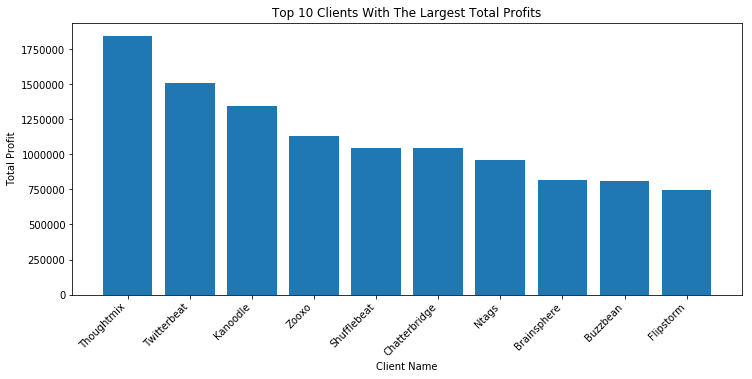

In [102]:
# test again, but this time round use N=10
TopN(10)

#### <font color = "purple"> Q2: Are there any clients for which profit is declining?<font>
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.

#### Q2 Part 1: Yearly Trend

**The most straightforward approach is to aggregate total yearly profits of each client. We will be able to observe the trend with some visualizations.**

The analysis is done in three steps:
1. Query the database to obtain yearly profits of each client.
2. Plot bar graphs to achieve a more direct understanding.
3. Conclude on clients with declining profits.

In [103]:
# SQL query to find the total profits from each company in each year
c.execute('''
SELECT company, SUM(standardized_USD), year
FROM customer
GROUP BY company, year
''')
yearlyAggre=c.fetchall()

In [104]:
# function to plot the yearly profits of a single client
# this function takes in a string which is a client name and return a bar plot
def get_one_yearly_plot(name):
    
    value=[x[1] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]
    year=[x[2] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]

    plt.bar(x=year, height=value, color = "#cd7f7d")
    plt.xticks(year, year)
    plt.title("Yearly Profits of {}".format(name))
    plt.xlabel("Year")
    plt.ylabel("Total Profits in USD")
    plt.show()
    return None

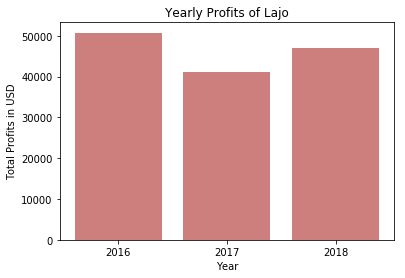

In [105]:
# example
# use this function when the boss wants to have a closer look at a particular client
get_one_yearly_plot('Lajo')

In [106]:
# function to plot the yearly profits of ALL clients at once
# this function does not take in any parameter and return plots for all clients
def get_all_yearly_plots():    
    fig, ax = plt.subplots(7, 4, figsize=(15,15))
    plt.subplots_adjust(wspace = 0.8, hspace = 1)
    
    for index, name in enumerate(df.company.unique()):
        
        value=[x[1] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]
        year=[x[2] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]
        
        row = index//4
        col = index%4
        
        ax[row, col].set_title("Yearly Profits of {}".format(name))
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Total Profits in USD")
        ax[row, col].bar(x=year, height=value, color = "#cd7f7d")
    return None

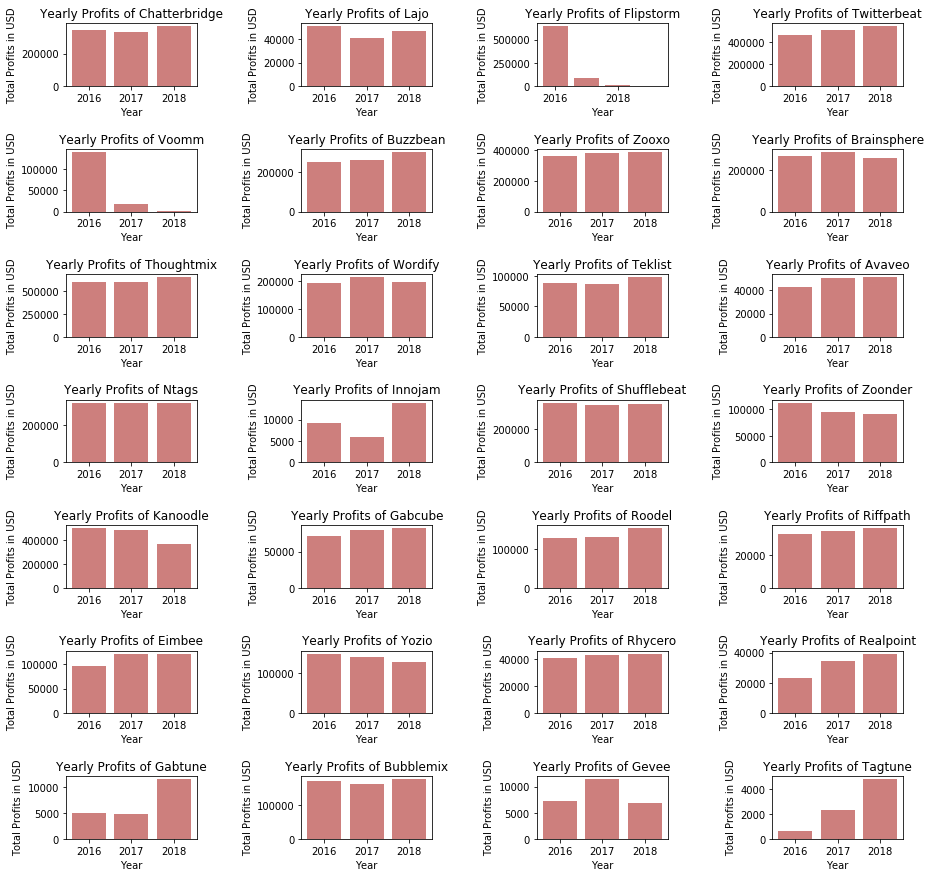

In [107]:
# use this when the boss is interested in the yearly profits of each and every company
get_all_yearly_plots()

**Sectional Conclusion: From the yearly trends, it can be seen that the clients with declining profits are: <font color='purple'> Flipstorm, Voomm, Zoonder, Kanoodle and Yozio</font>.**

#### Q2 Part 2: Monthly Trend

**A analytical approach can be more convincing than a visualization approach. Since there are more time steps if monthly interval is adopted, we could treat the data as a Time Series (there are only 3-4 time steps in yearly data which makes them less suitable for time series analysis). Hopefully it will shed more light on which the underperforming clients are.**

The analysis is done in several steps:

1. Query the database to obtain the time series of each client.
2. Plot the monthly profits of each client.
3. Calculate and plot the simple moving average profits of each client, based on its original time series.
4. Fit a linear line to the moving average time series. Gradient of the fitted line gives us insight into whether a client's profits is on the decline. i.e. if the gradient is negative, the profit of the client is likely to be declining.
5. Conclude on clients with declining profits.

In [108]:
# fetch data from the database
c.execute('''
SELECT company, year, month, SUM(standardized_USD)
FROM customer
GROUP BY company, year, month
''')

Time_Series=c.fetchall()

Define function that queries the moving average profits and the gradient of the fitted line on the moving average of different clients.

In [109]:
# function to get the profits of a client
# this function takes in a client name and returns the corresponding time series data
def getCompany(name):
    return list(filter(lambda x : x[0]==name, Time_Series))

# function to get the monthly moving average of the profits of a certain client
def getMA(name):
    lst = getCompany(name)
    data=[x[3] for x in lst]
    ma = bn.move_mean(data, window=3, min_count=3)
    ma = ma[2:]
    return ma

# function to get the gradient of the moving average profits. 
# This will help us understand whether the profits of a particular client is on the decline (gradient is negative)
def getGradient(name):
    lst = getCompany(name)
    lst=decomposeList(3,lst)
    m,b = np.polyfit([x for x in range(len(lst))], lst, 1)
    return m

# function to list down the gradients of the moving average profits for all companies. 
def get_all_gradients():
    grad_dict = {}
    for name in df.company.unique():
        grad_dict[name] = getGradient(name)
    return grad_dict

Define functions that plot the actual monthly profits and moving average monthly profits of different clients.

In [110]:
# function to plot the monthly profits of a client
def get_one_monthly_plot(name):
    lst = getCompany(name)
    plt.plot(decomposeList(3,lst))
    plt.title("Monthly Profits of {}".format(name))
    plt.xlabel("Month")
    plt.ylabel("Total Profits in USD")
    plt.show()

    
# function to plot the moving average of the monthly profits of a client
def get_one_monthly_MA_plot(name):
    lst = getMA(name)
    plt.plot(lst)
    plt.title("Monthly Moving Average Profits of {}".format(name))
    plt.xlabel('Month')
    plt.ylabel('Total Profits (MA) in USD')
    plt.show()


# function to plot the monthly profits of ALL clients at once
def get_all_monthly_plots():    
    fig, ax = plt.subplots(7, 4, figsize=(25,15))
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index, name in enumerate(df.company.unique()):
        lst = getCompany(name)
        row = index//4
        col = index%4
        ax[row, col].set_title("Monthly Profits of {}".format(name))
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Total Profits in USD")
        ax[row, col].plot(decomposeList(3,lst))
        

# function to plot the moving average of the monthly profits of ALL clients at once
def get_all_monthly_MA_plots():    
    fig, ax = plt.subplots(7, 4, figsize=(25,15))
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index, name in enumerate(df.company.unique()):
        lst = getMA(name)
        row = index//4
        col = index%4      
        ax[row, col].set_title("Monthly Moving Average Profits of {}".format(name))
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Total Profits (MA) in USD")
        ax[row, col].plot(lst)

Let's test it out:

Get the profits plot and the moving average plot of a random client:

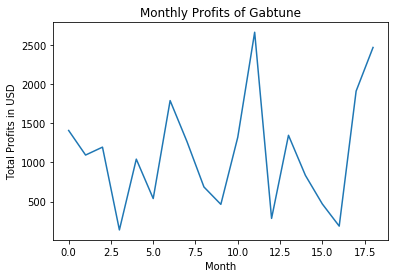

In [111]:
# example
# use this function when the boss wants to see the monthly profit changes of a specific company
get_one_monthly_plot("Gabtune")

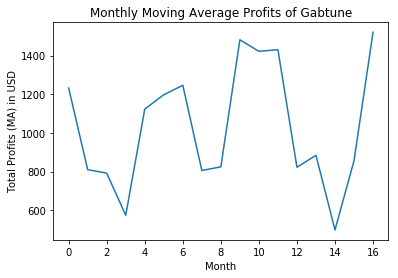

In [112]:
# example
# use this function when the boss wants to see the monthly moving average profit changes of a specific company
get_one_monthly_MA_plot("Gabtune")

Get the gradient of fitted line on the moving average profits of a random company:

In [113]:
getGradient("Gabtune")

21.223491905263124

Get the actual profits plots for all clients:

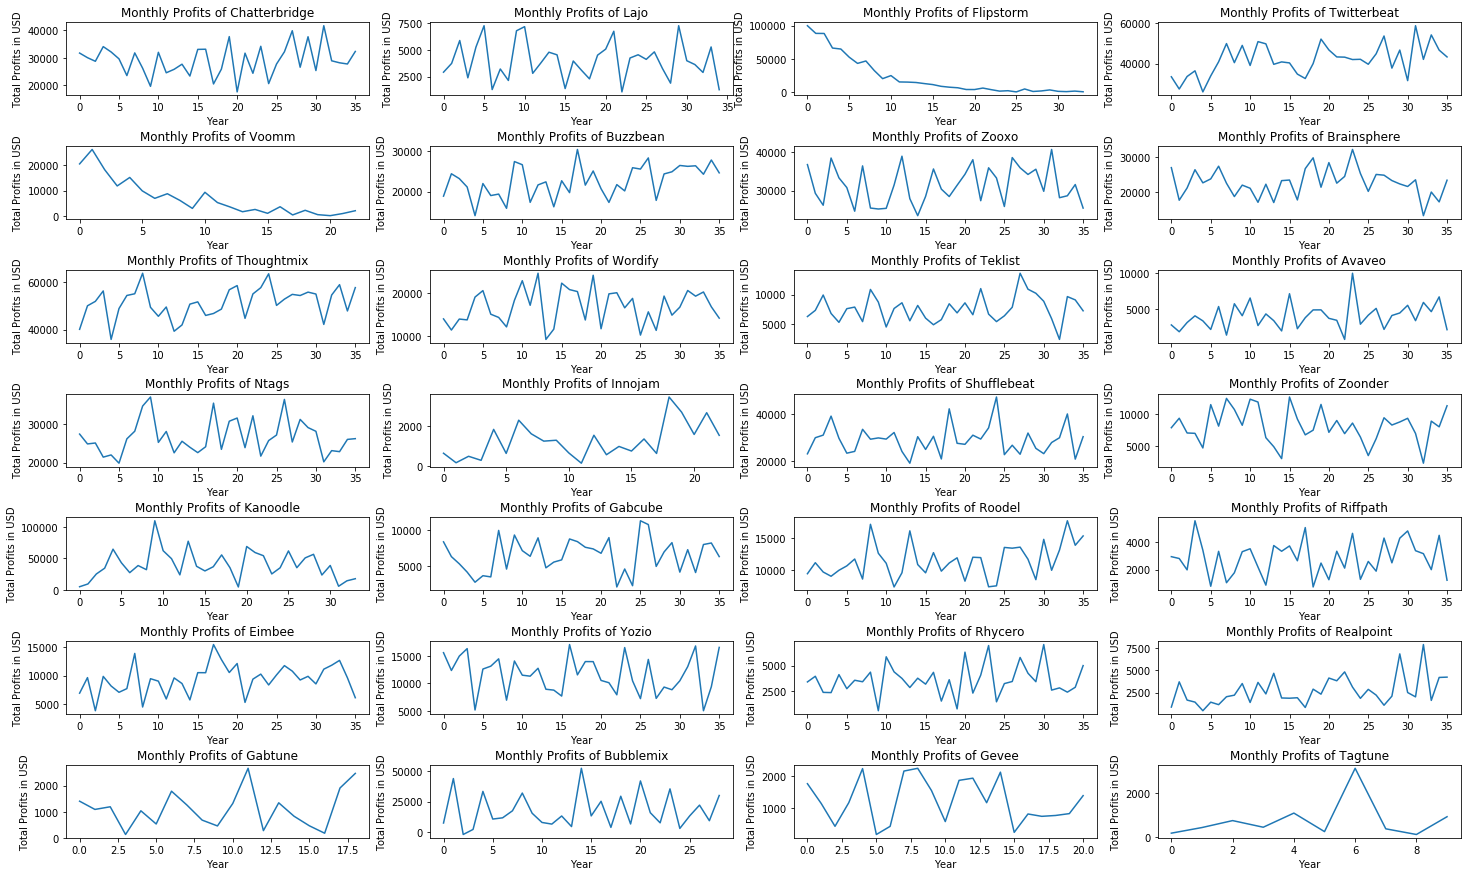

In [114]:
# use this function when the boss wants to see the monthly profit changes of each and every company
get_all_monthly_plots()

Get the moving average profits plots for all clients:

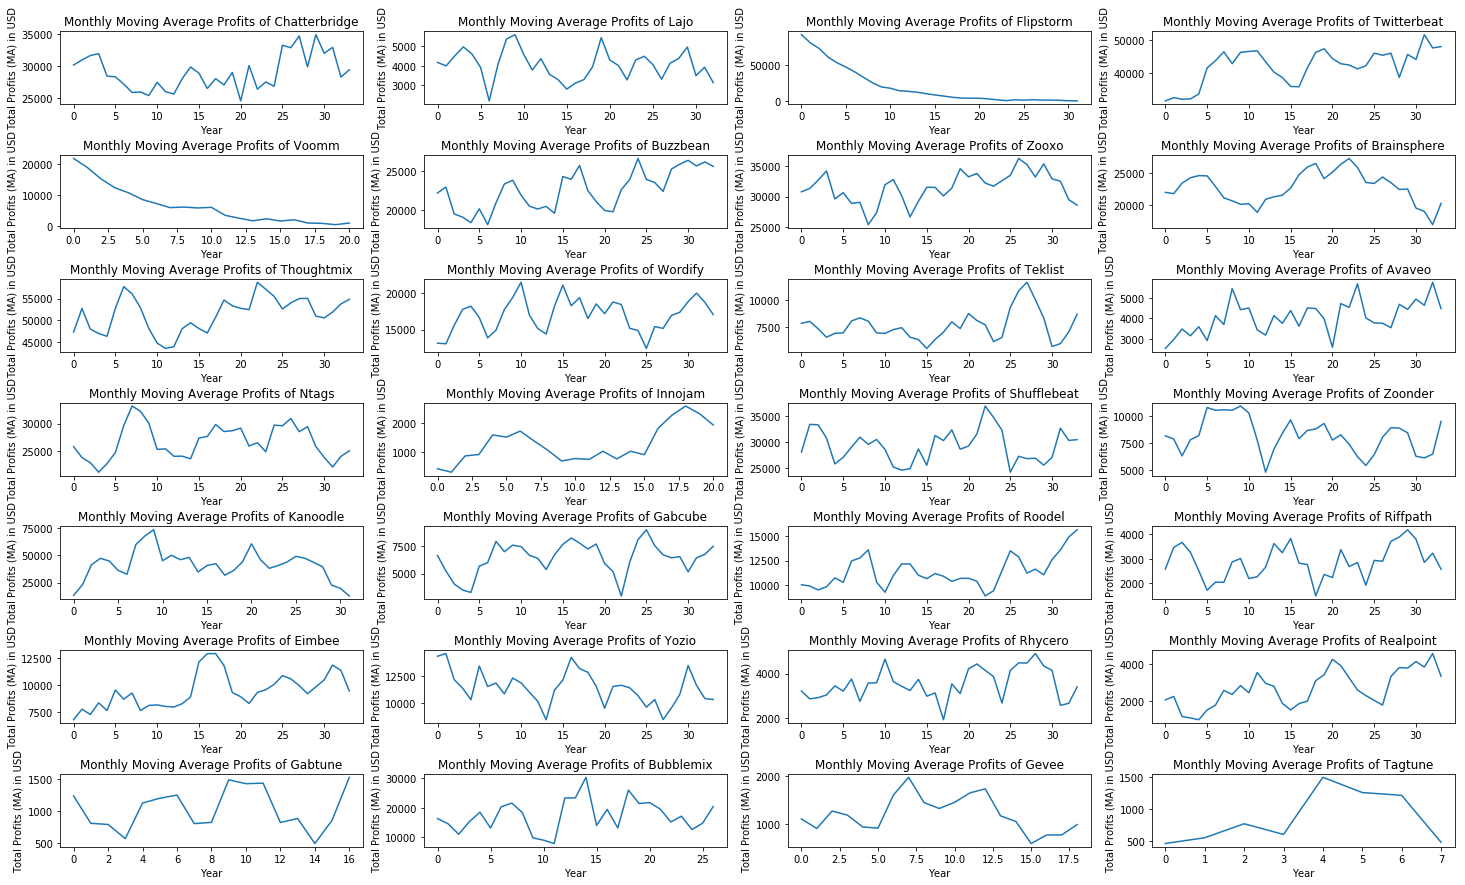

In [115]:
# use this function when the boss wants to see the monthly moving average profit changes of each and every company
get_all_monthly_MA_plots()

**Sectional Conclusion: From the moving average plots, it can be seen that the clients with declining profits are: <font color='purple'> Flipstorm, Voomm and Kanoodle</font>.**

Get the gradients of the fitted line on moving average profits of all clients:

In [116]:
MA_gradients = get_all_gradients()

In [117]:
MA_gradients

{'Chatterbridge': 73.00473072380986,
 'Lajo': -13.060374587394968,
 'Flipstorm': -2473.295320860658,
 'Twitterbeat': 338.08871982625493,
 'Voomm': -910.597914936759,
 'Buzzbean': 168.2310855159589,
 'Zooxo': 47.542240370952435,
 'Brainsphere': -27.96259046023168,
 'Thoughtmix': 198.2833320366796,
 'Wordify': 47.75640154440165,
 'Teklist': 32.008935134491566,
 'Avaveo': 40.9108215767053,
 'Ntags': 22.951252164092704,
 'Innojam': 64.41243689920951,
 'Shufflebeat': 8.09354422007754,
 'Zoonder': -34.19626512226513,
 'Kanoodle': -163.94924532614112,
 'Gabcube': 31.56877691660235,
 'Roodel': 87.34362376525095,
 'Riffpath': 11.295114633075922,
 'Eimbee': 76.67344036782497,
 'Yozio': -54.12862009626761,
 'Rhycero': 20.511896769626773,
 'Realpoint': 66.58886718005148,
 'Gabtune': 21.223491905263124,
 'Bubblemix': 138.729329487719,
 'Gevee': -14.992198005194792,
 'Tagtune': 59.774831648484884}

Find out which clients' gradients are negative, i.e. identify clients with declining profits:

In [118]:
# may choose a different treshold for nagativity
# our group feels that -50 implies a significant decrease
Declining = list(filter(lambda x : x[1] < -50, MA_gradients.items()))
Declining

[('Flipstorm', -2473.295320860658),
 ('Voomm', -910.597914936759),
 ('Kanoodle', -163.94924532614112),
 ('Yozio', -54.12862009626761)]

In [119]:
# print companies whose profits are declining, as according to our group's criteria
Declining_companies = list([x[0] for x in Declining])
Declining_companies

['Flipstorm', 'Voomm', 'Kanoodle', 'Yozio']

**Sectional Conclusion: From the gradients, it can be seen that the clients with declining profits are: <font color='red'> Flipstorm, Voomm, Kanoodle and Yozio <font>.**

**Overall Conclusion: From analysis above, <font color='red'> Flipstorm, Voomm and Kanoodle </font> appear in all sectional conclusions. We identify them as clients with declining profits.**

#### <font color = "purple"> Q3: Why did the unprofitable clients identified in Q2 experience a decline in profits? Provide reasons to their decline.</font>
This question falls in the realm of prescriptive analysis where we seek to identify the reasons behind such decline. Identifying the underlying reasons provides actionable insights into how to reverse the declining trend, as well as how to prevent such incidents from happening in the future. This will be valuable to the company in the long run.
    
In this question, we will focus on clients identified in Q2. We try to incorporate the external data (GDP and population) sourced in section 2, and explore its relationship with the declining clients. 

In [120]:
# fetch one company's yearly profits and the corresponding GDP & population in the company's home country
def get_one_profits_GDP_population(name): 

    c.execute('''
    SELECT c.company, SUM(c.standardized_USD), c.year, gdp.country, gdp.value, population.value
    FROM customer as c
    LEFT JOIN gdp
    On c.country = gdp.country AND c.year = gdp.year
    LEFT JOIN population
    ON c.country = population.country AND c.year= population.year
    Where company = ?
    GROUP BY company, c.year
    ''', (name,))
    
    lst = c.fetchall()
    return lst


# fetch ALL companies' yearly profits and the corresponding GDP & population in each company's home country
def get_multiple_profits_GDP_population(names):
    # INPUT ARGUMENT names: a list of strings containing the company names that are of interest
    lst = []
    for client in names:
        new_lst = get_one_profits_GDP_population(client)
        lst.append(new_lst)
    return lst    

Let's test it out:

In [121]:
# example
# get the corresponding yearly profits, GDP and population of a client, Lajo
get_one_profits_GDP_population("Lajo")

[('Lajo', 50737.16349899999, 2016, 'Greece', 195222000000.0, 10775971.0),
 ('Lajo', 41146.140186, 2017, 'Greece', 203086000000.0, 10754679.0),
 ('Lajo', 47082.81379600002, 2018, 'Greece', 218032000000.0, 10727668.0)]

In [122]:
# get the corresponding yearly profits, GDP and population of the declining clients identified in Qn2
get_multiple_profits_GDP_population(Declining_companies)

[[('Flipstorm', 641350.7544590005, 2016, 'Greece', 195222000000.0, 10775971.0),
  ('Flipstorm', 91601.54159000004, 2017, 'Greece', 203086000000.0, 10754679.0),
  ('Flipstorm', 12361.454862, 2018, 'Greece', 218032000000.0, 10727668.0),
  ('Flipstorm', 1350.0662879999998, 2019, None, None, None)],
 [('Voomm', 141625.99449399996, 2016, 'France', 2471290000000.0, 66859768.0),
  ('Voomm', 17141.994736, 2017, 'France', 2586290000000.0, 66865144.0),
  ('Voomm', 2111.249652, 2018, 'France', 2777540000000.0, 66987244.0)],
 [('Kanoodle', 500526.7224075931, 2016, 'Japan', 4926670000000.0, 126994511.0),
  ('Kanoodle',
   482435.26812154154,
   2017,
   'Japan',
   4859950000000.0,
   126785797.0),
  ('Kanoodle',
   364321.6503773853,
   2018,
   'Japan',
   4970920000000.0,
   126529100.0)],
 [('Yozio', 148407.117236, 2016, 'Greece', 195222000000.0, 10775971.0),
  ('Yozio', 139767.79223399993, 2017, 'Greece', 203086000000.0, 10754679.0),
  ('Yozio', 128742.72850200004, 2018, 'Greece', 218032000000

In [123]:
# function to plot the yearly profits of a client and the corresponding GDP, population of the client's country of origin
def plot_one_profits_GDP_population(name):
    
    lst = get_one_profits_GDP_population(name)   
    profits = list(map(lambda x:x[1], lst))
    year = list(map(lambda x:x[2], lst))
    country = list(map(lambda x:x[3], lst))
    gdp = list(map(lambda x:x[4], lst))
    population = list(map(lambda x:x[5], lst))
        
    fig, ax = plt.subplots(1, 3, figsize=(15,1), sharex = True)
    plt.subplots_adjust(wspace = 0.4, hspace = 1.5)
    plt.xticks(year, year)
    
    # generate a random color from the colormap "viridis"
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 15))
    rand_color = list(random.choice(colors))
    
    ax[0].plot(year, profits, color=rand_color)
    ax[1].plot(year, gdp, color=rand_color)
    ax[2].plot(year, population, color=rand_color)

    ax[0].set_ylabel("Total Profits in USD")
    ax[1].set_ylabel("GDP")
    ax[2].set_ylabel("Population")
        
    ax[0].set_title("Profits of {}".format(name))
    ax[1].set_title("GDP of {}".format(country[0]))
    ax[2].set_title("Population of {}".format(country[0]))

In [124]:
# function to plot the yearly profits of multiple clients and the corresponding GDP, population of their countries of origin
def plot_multiple_profits_GDP_population(names):
    for name in names:
        plot_one_profits_GDP_population(name)

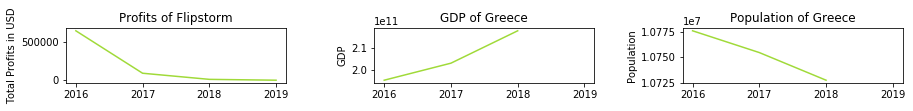

In [125]:
# example
# plot the relevant information of Flipstorm
plot_one_profits_GDP_population("Flipstorm")

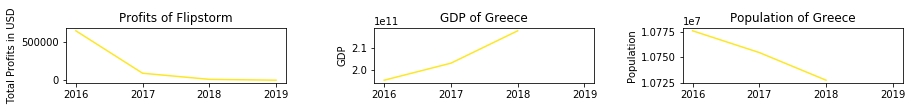

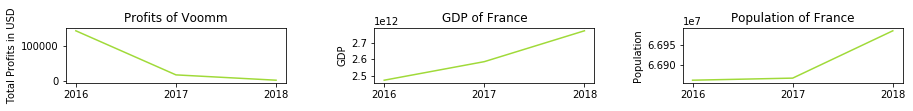

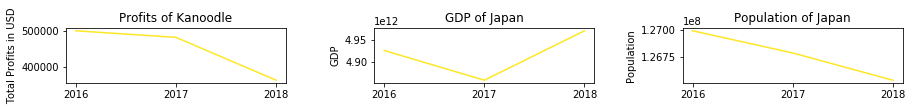

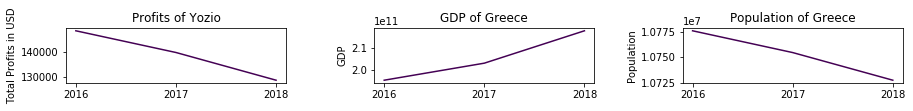

In [126]:
# plot the relevant information of all declining companies
plot_multiple_profits_GDP_population(Declining_companies)

**Conclusion 1: It can be seen that while profits of the clients are declining, GDP of these clients' countries are on the rise and populations are on the decline. We can conclude that population and profit often have a positive association while GDP and profit have a negative association. <font color='red'> However, association does not imply causation so we cannot conclude anything on the causal relationship</font>.**

To further testify our conclusion made above, plot the remaining firms to see if the rising GDP & declining population trends apply to them. If these trends are only observed in declining firms, we can confidently conclude that GDP and population are indeed associated with declining profits. Otherwise, our conclusion may not hold.

In [127]:
# find the list of non-declining companies
Non_declicing_companies = list(set(df.company.unique()).difference(Declining_companies))
Non_declicing_companies

['Zooxo',
 'Realpoint',
 'Tagtune',
 'Chatterbridge',
 'Shufflebeat',
 'Riffpath',
 'Lajo',
 'Wordify',
 'Roodel',
 'Teklist',
 'Eimbee',
 'Bubblemix',
 'Thoughtmix',
 'Gabcube',
 'Ntags',
 'Twitterbeat',
 'Brainsphere',
 'Innojam',
 'Buzzbean',
 'Rhycero',
 'Zoonder',
 'Gevee',
 'Avaveo',
 'Gabtune']

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


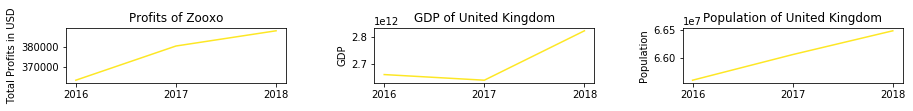

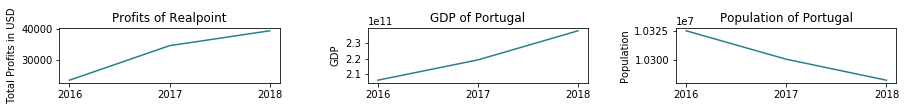

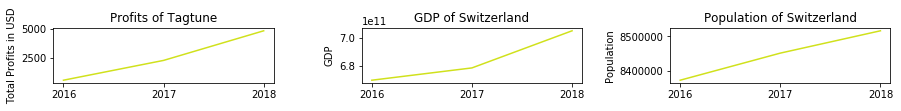

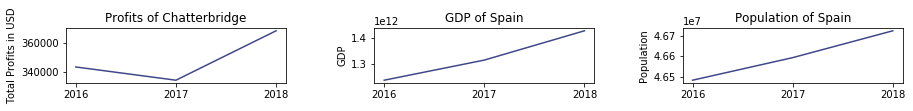

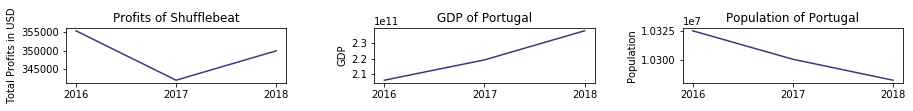

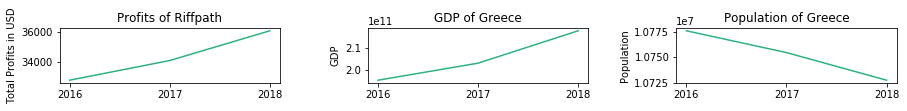

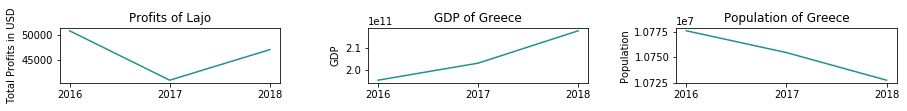

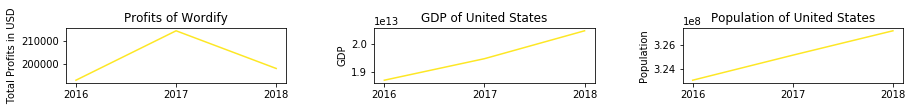

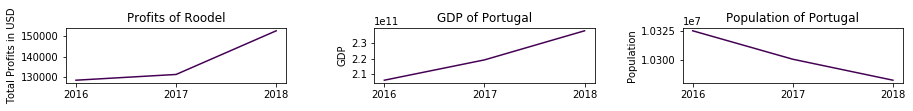

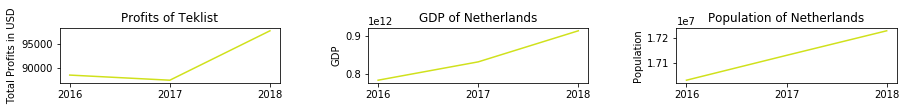

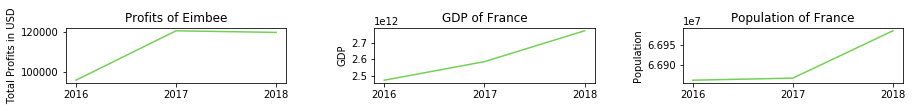

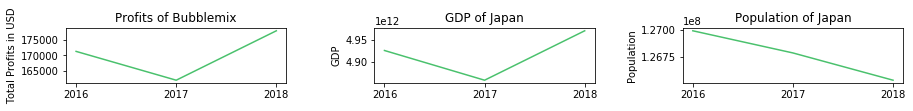

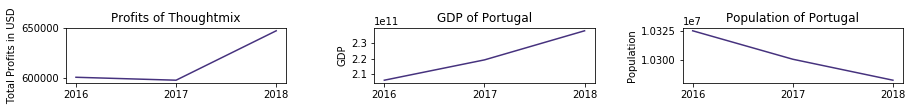

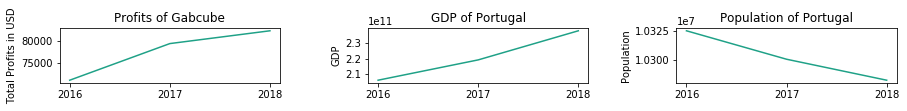

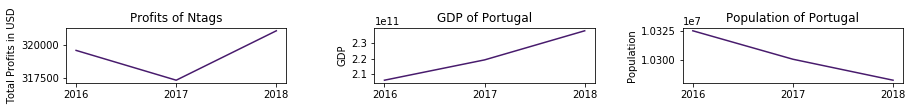

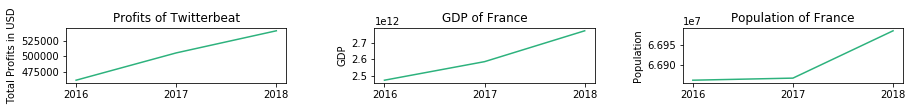

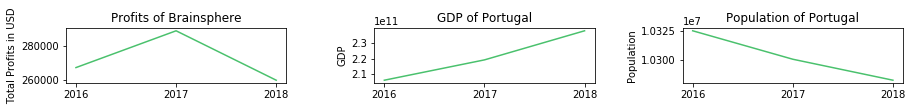

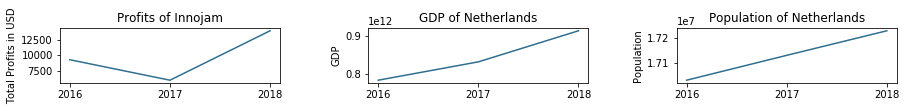

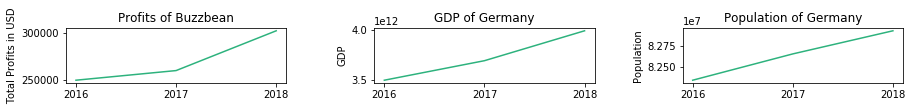

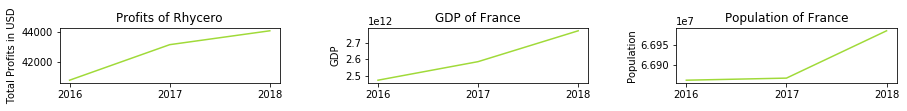

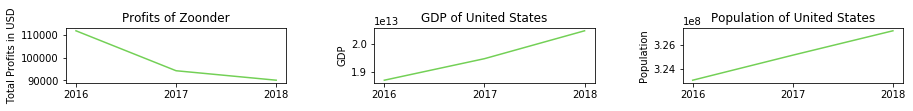

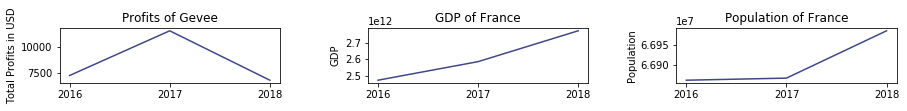

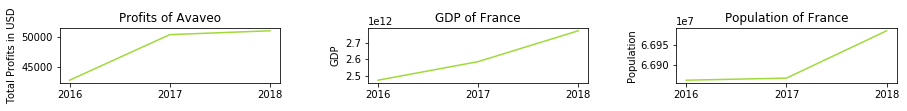

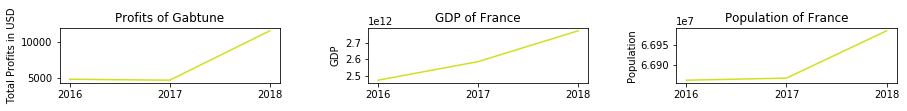

In [128]:
# plot the relevant information of all declining companies
plot_multiple_profits_GDP_population(Non_declicing_companies)

**Conclusion 2: From the plots on the non-declining companies, it can be seen that there are quite a number of companies with rising GDP and declining population, a trend that we only expect to see in the declining firms. Therefore, our final conclusion is that <font color = "red">there is no clear association between GDP & population and a client's profits. In other words, increase in GDP and decrease in population does not does not have a significant impact on a client's declining profits </font>**

#### <font color = "purple"> Q4: Which clients have lower risks than the rest? </font>

**To define low risk, our group would like to define two indicator:**
1. <font color = "red">Risk_Count_Fraction</font> = Number of negative profit occurrence / Number of postive profit occurrence
2. <font color = "red">Risk_Amount_Fraction</font> = Total negative profit (loss) / Total positive profit

In [129]:
# query companies with nagetive profits
c.execute('''
SELECT company, COUNT(*) as counts, SUM(standardized_USD)
FROM customer
Where standardized_USD < 0
GROUP BY company
ORDER BY company
''')

negative=c.fetchall()

In [130]:
# query companies with positive profits
c.execute('''
SELECT company, COUNT(*) as counts, SUM(standardized_USD)
FROM customer
Where standardized_USD > 0
GROUP BY company
ORDER BY company
''')

positive=c.fetchall()

In [131]:
# get the risk_count_fraction and risk_amount fraction of each company
def get_Fractions():
    res=[]
    nagetive_name_list=[x[0] for x in negative]
    
    for record in positive:
        name = record[0]
        positive_count=record[1]
        positive_profit=record[2]
        if name not in nagetive_name_list:
            negative_count = 0
            negative_profit = 0
        else:
            index=nagetive_name_list.index(name)
            negative_count = negative[index][1]
            negative_profit = abs(negative[index][2])
        res.append([name,
                    negative_count/positive_count,
                    negative_profit/positive_profit])
    return res

In [132]:
# the first element is client name
# the second is risk_count_fraction 
# the last is risk_amount_fraction
risk=get_Fractions()
risk

[['Avaveo', 0.0, 0.0],
 ['Brainsphere', 0.0032441200324412004, 0.0005157542640472776],
 ['Bubblemix', 0.038461538461538464, 0.004699271979062853],
 ['Buzzbean', 0.0032076984763432237, 0.00048327752851247104],
 ['Chatterbridge', 0.004430379746835443, 0.0009802447504396329],
 ['Eimbee', 0.004032258064516129, 0.00042901679303672526],
 ['Flipstorm', 0.004212299915754001, 0.000649728276810013],
 ['Gabcube', 0.0028169014084507044, 0.000248972756070647],
 ['Gabtune', 0.0, 0.0],
 ['Gevee', 0.0, 0.0],
 ['Innojam', 0.0, 0.0],
 ['Kanoodle', 0.016129032258064516, 0.002021279811247624],
 ['Lajo', 0.0, 0.0],
 ['Ntags', 0.0026595744680851063, 0.0007150702160616229],
 ['Realpoint', 0.0, 0.0],
 ['Rhycero', 0.009900990099009901, 0.00188648848466871],
 ['Riffpath', 0.0, 0.0],
 ['Roodel', 0.0016025641025641025, 4.7311888947651426e-05],
 ['Shufflebeat', 0.0038885288399222295, 0.0005690860304486575],
 ['Tagtune', 0.0, 0.0],
 ['Teklist', 0.0, 0.0],
 ['Thoughtmix', 0.003606202668589975, 0.0006958460045972119]

In [133]:
# function takes in an integer and returns top N top risky client by risk_count_fraction
def TopN_risky_count(N):
    return sorted(risk, key=lambda x : x[1], reverse = True)[:N]

# function takes in an integer and returns top N top risky client by risk_amount_fraction
def TopN_risky_amount(N):
    return sorted(risk, key=lambda x : x[2], reverse = True)[:N]

In [134]:
# top 5 most risky clients by risk_count_fraction
TopN_risky_count(5)

[['Bubblemix', 0.038461538461538464, 0.004699271979062853],
 ['Kanoodle', 0.016129032258064516, 0.002021279811247624],
 ['Rhycero', 0.009900990099009901, 0.00188648848466871],
 ['Zoonder', 0.0044444444444444444, 0.0004371634386206277],
 ['Chatterbridge', 0.004430379746835443, 0.0009802447504396329]]

In [135]:
# top 5 most risky clients by risk_amount_fraction
TopN_risky_amount(5)

[['Bubblemix', 0.038461538461538464, 0.004699271979062853],
 ['Kanoodle', 0.016129032258064516, 0.002021279811247624],
 ['Rhycero', 0.009900990099009901, 0.00188648848466871],
 ['Zooxo', 0.00421179302045728, 0.0013845192965767493],
 ['Chatterbridge', 0.004430379746835443, 0.0009802447504396329]]

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

#### <font color = "purple">Q1: Show all sales to company X between time  𝑡1  and time  𝑡2</font>

In [136]:
# function to return sales to a specific company between t1 and t2
def betweenTime(Company,T_start,T_end):
    substitution=(Company,T_start,T_end)
    
    c.execute('''
    SELECT part, company, country, city, date, price, standardized_USD
    FROM customer 
    Where company = ? AND date Between ? AND ? 
    ''', substitution)
    
    return c.fetchall()

let's test it out:

In [137]:
# example
betweenTime('Chatterbridge','2016-01-02','2016-01-03')

[('54868-5165',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 00:01:05',
  '784.79€',
  854.4008729999999),
 ('44946-1046',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 04:51:55',
  '412.55€',
  449.143185),
 ('16729-167',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 07:20:59',
  '359.52€',
  391.409424)]

#### <font color = "purple">Q2: Show the latest X sales in the database</font>

In [138]:
# function to return the latest x number of sales
def latest(x):
    substitution=(x,)
    
    c.execute('''
    SELECT part, company, country, city, date, price, standardized_USD
    FROM customer 
    Order BY date DESC
    LIMIT ?
    ''', substitution)
    
    return c.fetchall()

let's test it out:

In [139]:
latest(5)

[('43419-018',
  'Flipstorm',
  'Greece',
  'Athens',
  '2019-05-14 22:48:39',
  '139.56€',
  156.67005600000002),
 ('49288-0285',
  'Flipstorm',
  'Greece',
  'Athens',
  '2019-02-21 20:05:00',
  '1051.08€',
  1193.3962319999998),
 ('52343-025',
  'Brainsphere',
  'Portugal',
  'Braga',
  '2018-12-31 21:38:02',
  '686.1€',
  785.5845),
 ('49999-737',
  'Thoughtmix',
  'Portugal',
  'Amadora',
  '2018-12-31 21:24:17',
  '828.37€',
  948.48365),
 ('21695-267',
  'Roodel',
  'Portugal',
  'Aranhas',
  '2018-12-31 20:48:14',
  '606.37€',
  694.2936500000001)]

#### <font color = "purple">Q3: Show total sales per company per day</font>

In [140]:
# function to show the total sales per company per day
def salesPerCompanyPerDay():
    
    c.execute('''
    SELECT company, DATE(date) , SUM(standardized_USD)
    FROM customer 
    Group BY company, Date(date)
    ''')
    
    return c.fetchall()

let's test it out:

In [141]:
salesPerCompanyPerDay()

[('Avaveo', '2016-01-03', 1121.2739040000001),
 ('Avaveo', '2016-01-06', 738.652146),
 ('Avaveo', '2016-01-18', 390.43463199999997),
 ('Avaveo', '2016-01-19', 515.52358),
 ('Avaveo', '2016-02-01', 150.645444),
 ('Avaveo', '2016-02-11', 831.723753),
 ('Avaveo', '2016-02-20', 833.165352),
 ('Avaveo', '2016-03-07', 420.387093),
 ('Avaveo', '2016-03-08', 969.0193320000001),
 ('Avaveo', '2016-03-18', 563.1604699999999),
 ('Avaveo', '2016-03-20', 185.336528),
 ('Avaveo', '2016-03-22', 965.330776),
 ('Avaveo', '2016-04-02', 410.831784),
 ('Avaveo', '2016-04-12', 530.210296),
 ('Avaveo', '2016-04-13', 1854.3746339999998),
 ('Avaveo', '2016-04-14', 519.22354),
 ('Avaveo', '2016-04-18', 723.75359),
 ('Avaveo', '2016-05-10', 117.333125),
 ('Avaveo', '2016-05-12', 1147.134247),
 ('Avaveo', '2016-05-13', 525.616664),
 ('Avaveo', '2016-05-20', 1357.3307149999998),
 ('Avaveo', '2016-05-27', 187.410208),
 ('Avaveo', '2016-06-11', 1171.015272),
 ('Avaveo', '2016-06-16', 964.271504),
 ('Avaveo', '2016-0

---